In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
from PIL import Image
import torch
import torch.utils
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, utils, transforms
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, plot_confusion_matrix

In [2]:
# Define paths and set GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Define transforms (data augmentation)

train_tfms = transforms.Compose([transforms.ToTensor(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.RandomRotation(degrees=(0, 180))])
test_tfms = transforms.Compose([transforms.ToTensor()])

In [4]:
# Initialize datasets and pass to dataloaders

train_ds = datasets.ImageFolder('final_gi/train', train_tfms)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = datasets.ImageFolder('final_gi/val', train_tfms)
val_dl = DataLoader(val_ds, batch_size=10, shuffle=True)

test_ds = datasets.ImageFolder('final_gi/test', test_tfms)
test_dl = DataLoader(test_ds, batch_size=10, shuffle=True)

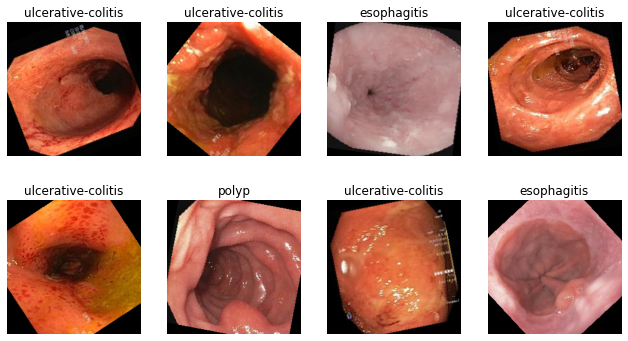

In [ ]:
# Explore data

def showimages(imgs,actual_lbls):
  fig = plt.figure(figsize=(11,6))
  for i,img in enumerate(imgs[:8]):
    fig.add_subplot(2,4,i+1)
    y=actual_lbls[i]
    title=train_ds.classes[y]
    plt.title(title)
    img = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    plt.imshow(img)
plt.show()
inputs, classes = next(iter(train_dl))
showimages(inputs,classes)

In [ ]:
# Define Resnet architecture

model = torchvision.models.resnet50(pretrained=True) # fine tuning

classes = train_ds.classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training and validation

n_epochs = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    
    # Training
    
    train_epoch_loss = 0.0
    train_epoch_correct = 0
    train_epoch_total = 0
    
    for data in train_dl:
        train_X, train_y = data # get data
        train_X = train_X.to(device)
        train_y = train_y.to(device)

        optimizer.zero_grad()
        outputs = model(train_X) # make prediction
        loss = criterion(outputs, train_y) # calculate cross entropy loss to know how good the model is
        loss.backward() # calculate gradient which measures for each weight how changing that weight woud change the loss
        optimizer.step() # change the weights based on that calculation

        train_epoch_loss += loss.item()
        _, train_pred = torch.max(outputs, dim=1) # find max for each batch image
        train_epoch_correct += torch.sum(train_pred==train_y).item()
        train_epoch_total += train_y.size(0)

    train_acc.append(100*train_epoch_correct/train_epoch_total)
    train_loss.append(train_epoch_loss/len(train_dl))
    
    print(f'train-loss: {np.mean(train_loss):.4f}, train-acc: {(100*train_epoch_correct/train_epoch_total):.4f}')

    # Validation
    
    val_epoch_loss = 0
    val_epoch_total = 0
    val_epoch_correct = 0
    
    with torch.no_grad():
        model.eval()

        for data in val_dl:
            val_X, val_y = data # get data
            val_X = val_X.to(device)
            val_y = val_y.to(device)
            
            outputs = model(val_X)
            loss = criterion(outputs, val_y)
            val_epoch_loss += loss.item()
            
            _, val_pred = torch.max(outputs, dim=1)
            val_epoch_correct += torch.sum(val_pred==val_y).item()
            val_epoch_total += val_y.size(0)
    
    val_acc.append(100*val_epoch_correct/val_epoch_total)
    val_loss.append(val_epoch_loss/len(val_dl))

    print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100*val_epoch_correct/val_epoch_total):.4f}')

    if val_epoch_loss < valid_loss_min:
        valid_loss_min = val_epoch_loss
        torch.save(model.state_dict(), 'resnet50.pt')
        print('Improvement-Detected, save-model')
        
    model.train()

Epoch 1
train-loss: 0.5115, train-acc: 81.1001
validation loss: 0.1456, validation acc: 96.2796
Improvement-Detected, save-model
Epoch 2
train-loss: 0.3204, train-acc: 96.1636
validation loss: 0.1142, validation acc: 96.8433
Improvement-Detected, save-model
Epoch 3
train-loss: 0.2435, train-acc: 97.3202
validation loss: 0.1026, validation acc: 97.1815
Improvement-Detected, save-model
Epoch 4
train-loss: 0.2001, train-acc: 98.0536
validation loss: 0.0891, validation acc: 98.7599
Improvement-Detected, save-model
Epoch 5
train-loss: 0.1724, train-acc: 98.0818
validation loss: 0.0816, validation acc: 98.5344
Epoch 6
train-loss: 0.1528, train-acc: 98.1382
validation loss: 0.0782, validation acc: 98.1962
Epoch 7
train-loss: 0.1375, train-acc: 98.5049
validation loss: 0.0733, validation acc: 98.5344
Improvement-Detected, save-model
Epoch 8
train-loss: 0.1256, train-acc: 98.3639
validation loss: 0.0705, validation acc: 97.8579
Epoch 9
train-loss: 0.1157, train-acc: 98.8999
validation loss: 0.0

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


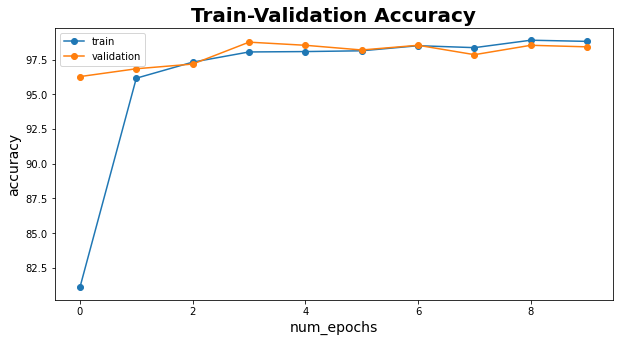

In [ ]:
title = {'fontname':'Arial', 'size':20, 'weight':'bold'}
label = {'fontname':'Arial', 'size':14, 'color': 'black'}

fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Accuracy", **title)
plt.plot(train_acc, label='train', marker='o')
plt.plot(val_acc, label='validation', marker='o')
plt.xlabel('num_epochs', **label)
plt.ylabel('accuracy', **label)
plt.legend(loc='best')

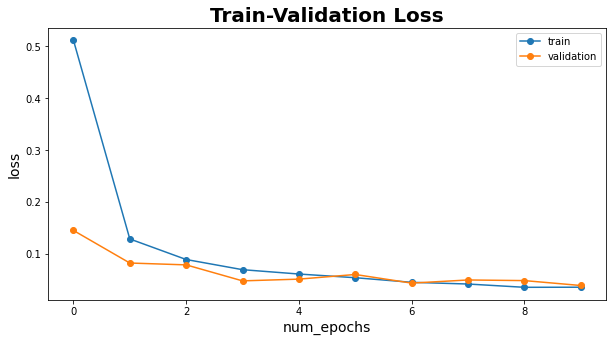

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Loss", **title)
plt.plot(train_loss, label='train', marker='o')
plt.plot(val_loss, label='validation', marker='o')
plt.xlabel('num_epochs', **label)
plt.ylabel('loss', **label)
plt.legend(loc='best')

In [ ]:
# Testing

images_list = []
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for data in test_dl:
        test_X, test_y = data # get data
        images_list.append(test_X)
        test_X = test_X.to(device)
        test_y = test_y.to(device)
        outputs = model(test_X)
        _, test_pred = torch.max(outputs, dim = 1)
        y_pred_list.append(test_pred.cpu().numpy())
        y_true_list.append(test_y.cpu().numpy())

                    precision    recall  f1-score   support

       esophagitis       0.97      0.95      0.96       333
             polyp       0.91      0.93      0.92       406
ulcerative-colitis       0.93      0.92      0.93       371

          accuracy                           0.93      1110
         macro avg       0.93      0.93      0.93      1110
      weighted avg       0.93      0.93      0.93      1110

Matthews Correlation Coefficient 0.8983291324947624


<AxesSubplot:>

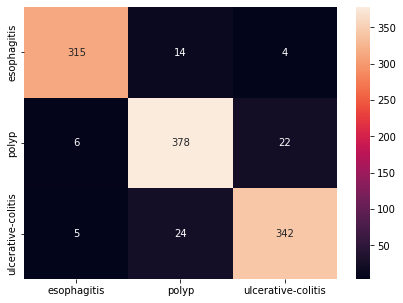

In [ ]:
y_pred = [x for sublist in y_pred_list for x in sublist]
y_true = [x for sublist in y_true_list for x in sublist]

print(classification_report(y_true, y_pred, target_names=classes))

matthews = matthews_corrcoef(y_true, y_pred)
print('Matthews Correlation Coefficient', matthews)

cm = pd.DataFrame(confusion_matrix(y_true, y_pred))
cm.index = classes
cm.columns = classes
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(cm, annot=True, ax=ax, fmt='g')

In [ ]:
images = [x for sublist in images_list for x in sublist]
pred_label = np.array(y_pred)
true_label = np.array(y_true)
index = ((pred_label == true_label) == False).nonzero()

img = []
pred = []
true = []

for i in range(len(index[0])):
    img.append(images[index[0][i]])
    pred.append(pred_label[index[0][i]])
    true.append(true_label[index[0][i]])

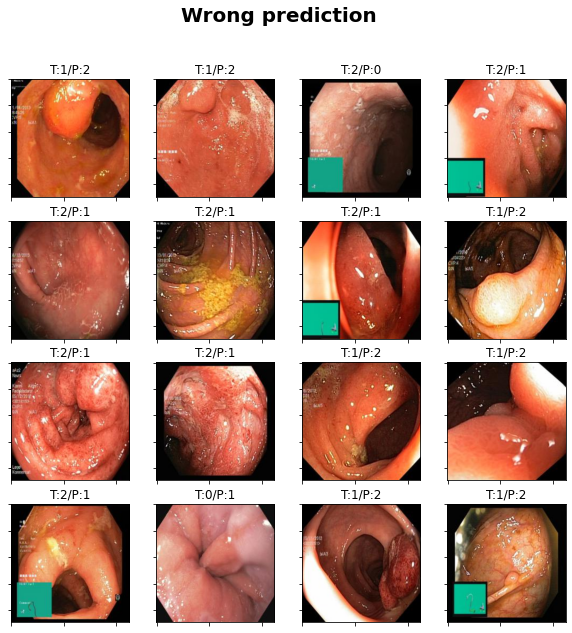

In [ ]:
title = {'fontname':'Arial', 'size':20, 'weight':'bold'}
tick = {'fontname':'Arial', 'size':9, 'color': 'black'}

transform = T.ToPILImage()
plt.figure(figsize=(10, 10))
plt.suptitle('Wrong prediction', **title)
for i in range(16):
    temp = transform(img[i])
    plt.subplot(4,4,i+1)
    plt.imshow(temp)
    plt.gca().set_title(f'T:{true[i]}/P:{pred[i]}')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])